# 1. Setup

## 1.1 Imports

In [1]:
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import bees_utils_macro as utils
import datetime

# importo librerias para la regularizacion
from tensorflow.keras.regularizers import l2


## 1.2 Set random seeds

In [2]:
np.random.seed(117)
tf.random.set_seed(117)

## 1.3 Global variables

In [3]:
img_width = 100
img_height = 100
img_channels = 3

# 2. Carga de datos

In [4]:
bees, bees_test_for_evaluation = utils.read_data()

In [5]:
bees.head()

,id,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,0,2018-08-06 14:48:00,020_011.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
1,1,2018-08-21 09:00:00,032_507.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
2,2,2018-08-21 09:00:00,032_612.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
3,3,2018-08-17 17:50:00,030_773.png,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
4,4,2018-08-06 13:19:00,015_1052.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [6]:
bees_test_for_evaluation.head()

,id,datetime,file,location,zip code,pollen_carrying,caste
0,0,2018-08-28 16:07:00,042_012.png,"Alvin, TX, USA",77511,False,worker
1,1,2018-08-10 13:54:00,022_114.png,"Saratoga, CA, USA",95070,False,worker
2,2,2018-08-18 12:30:00,038_384.png,"Athens, Georgia, USA",30607,False,worker
3,3,2018-08-17 17:50:00,030_740.png,"Alvin, TX, USA",77511,False,worker
4,4,2018-07-07 12:56:00,005_310.png,"Saratoga, CA, USA",95070,False,worker


# 3. Análisis exploratorio de datos

## 3.1 Análisis descriptivo: Distribuciones, Scatterplots, Barplots...

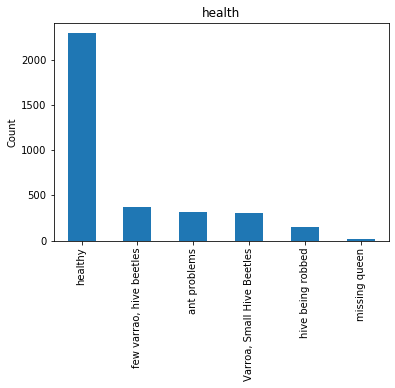

In [7]:
utils.value_counts(bees, 'health')

## 3.2 Ver imágenes

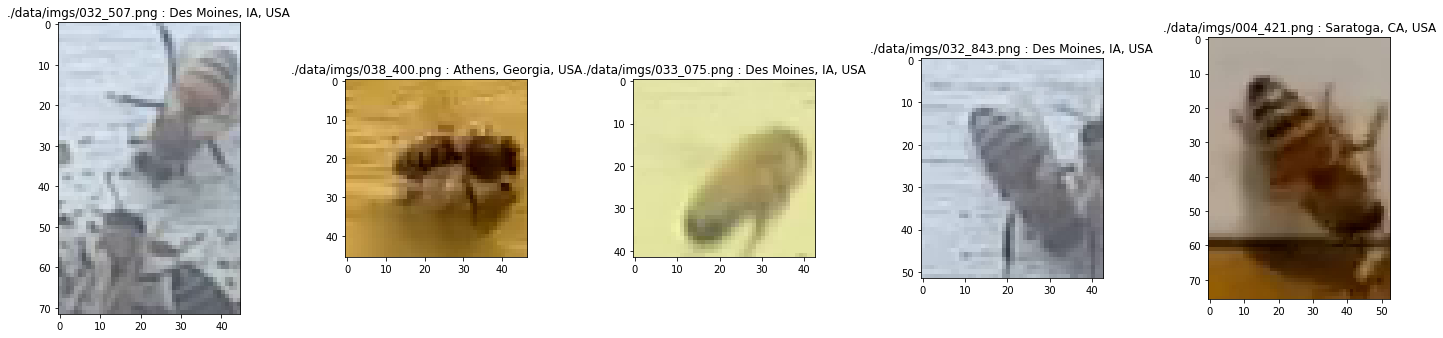

In [8]:
utils.plot_images(bees, 'location', [1, 25, 7, 100, 254])

# 4. Clasificación

## 4.1. Data preprocessing
### 4.1.1 Particionamiento

In [9]:
train_bees, val_bees, test_bees = utils.split(bees)


### 4.1.2 Carga de imágenes

In [10]:
# esta función ya uniformiza todas las imágenes en 100x100
train_X, val_X, test_X, train_y, val_y, test_y = utils.load_images_and_target(train_bees, 
                                                                              val_bees, 
                                                                              test_bees,
                                                                              'health',
                                                                              img_width, 
                                                                              img_height,
                                                                              img_channels)

In [11]:
train_bees['health']

225                      healthy
2453                     healthy
3009    few varrao, hive beetles
3270                     healthy
2622                     healthy
                  ...           
1275           hive being robbed
1439                     healthy
1175                ant problems
2765                     healthy
189                      healthy
Name: health, Length: 2338, dtype: category
Categories (6, object): [Varroa, Small Hive Beetles, ant problems, few varrao, hive beetles, healthy, hive being robbed, missing queen]

In [12]:
utils.categories['health']

array(['Varroa, Small Hive Beetles', 'ant problems',
       'few varrao, hive beetles', 'healthy', 'hive being robbed',
       'missing queen'], dtype=object)

In [13]:
utils.class_indices['health']

array([ 7,  8,  9, 10, 11, 12])

In [14]:
class_weights = utils.class_weights(bees, 'health')
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.9186046511627908,
 1: 1.8160377358490567,
 2: 1.5359042553191489,
 3: 0.2518534670737026,
 4: 3.725806451612903,
 5: 26.25}

## 4.2 CNN

In [15]:
optimizer = Adam(lr = 0.0001)
loss = 'categorical_crossentropy'

In [16]:
train_y.columns.size

6

In [17]:
model1 = Sequential(name = 'model1')
model1.add(Input((img_height, img_width, img_channels)))

model1.add(Conv2D(11, kernel_size=3, padding='same'))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(2))

model1.add(Conv2D(21, kernel_size=3, padding='same'))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(2))

model1.add(Conv2D(41, kernel_size=3, padding='same'))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(2))

#model1.add(Activation('relu'))
#model1.add(MaxPool2D(2))
#model1.add(Dropout(0.2))

#model1.add(Conv2D(32, kernel_size=3, padding='same'))
#model1.add(Activation('relu'))
#model1.add(MaxPool2D(2))
#model1.add(Dropout(0.2))

#model1.add(Conv2D(32, kernel_size=3, padding='same'))
#model1.add(Activation('relu'))
#model1.add(MaxPool2D(3))
#model1.add(Dropout(0.2))
           
# FC Layer
model1.add(Flatten())
model1.add(Dense(256, activation = 'relu'))
model1.add(Dropout(0.2))

# Output layer
model1.add(Dense(train_y.columns.size, activation = 'softmax'))


In [18]:
model1.compile(optimizer = optimizer, 
               loss = loss, 
               metrics = [utils.MacroAverageRecallMetric(num_classes = train_y.columns.size)])

In [19]:
model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 11)      308       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 11)      44        
_________________________________________________________________
activation (Activation)      (None, 100, 100, 11)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 11)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 21)        2100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 21)        84        
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 21)        0    

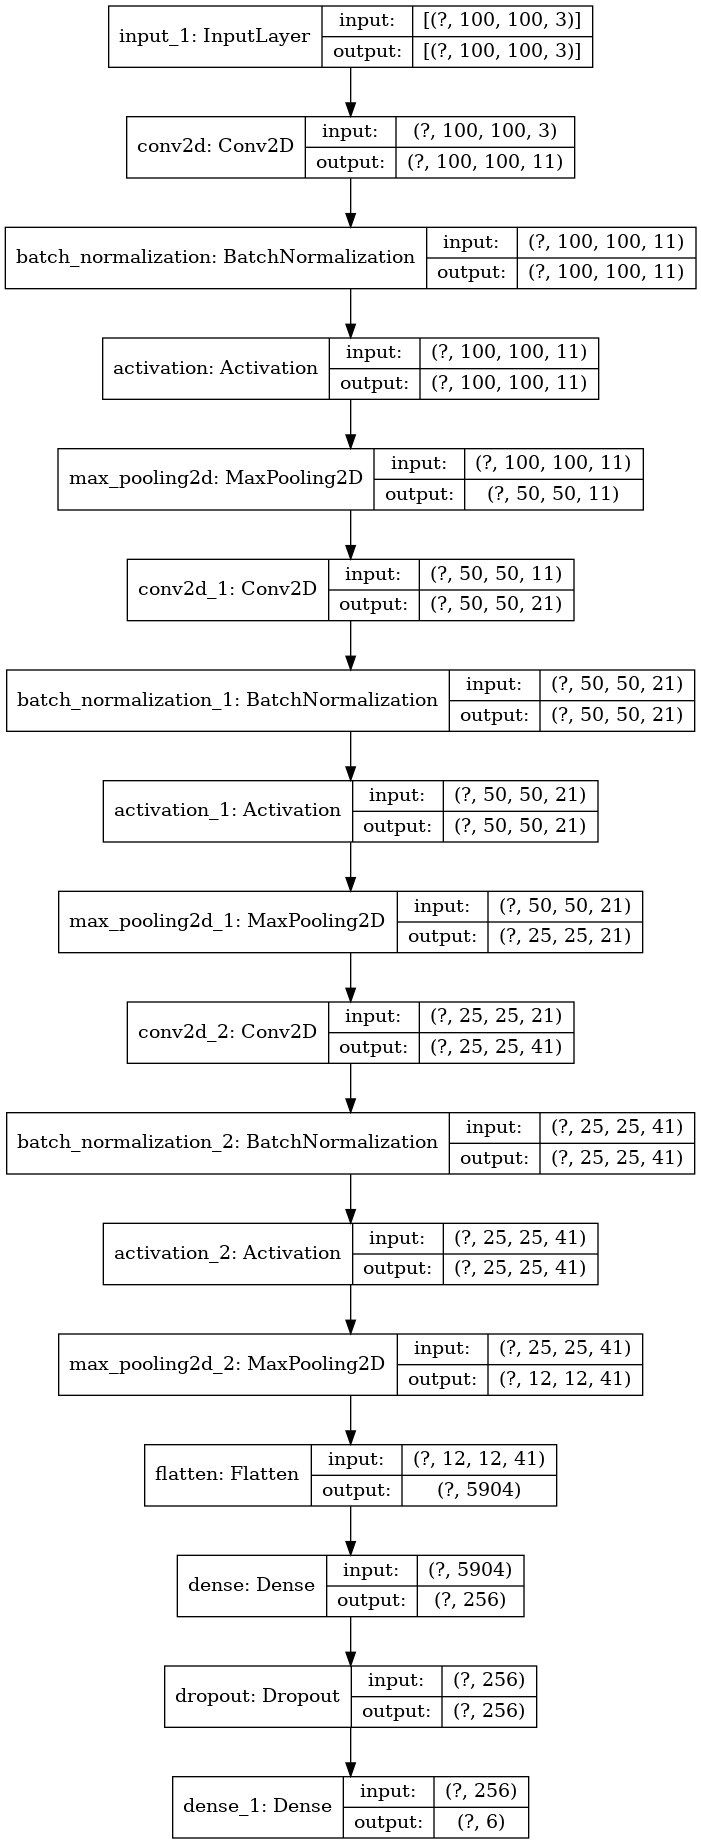

In [20]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
modelname = './models/' + model1.name + '_' + current_time
keras.utils.plot_model(model1, to_file = modelname + '.png', show_shapes = True)

## 4.3 Entrenamiento

### 4.2.2 Parámetros de transformación de imágenes (data augmentation)

In [21]:
rotation_range = 20     # rotación aleatoria en grados entre 0 a rotation_range
zoom_range = 0.2         # zoom aleatorio
width_shift_range = 0.3  # desplazamiento horizontal aleatorio (fracción del total)
height_shift_range = 0.3 # desplazamiento vertical aleatorio (fracción del total)
horizontal_flip = True   # transposición horizontal
vertical_flip = True     # transposición horizontal

#rotation_range = 180     # rotación aleatoria en grados entre 0 a rotation_range
#zoom_range = 0.1         # zoom aleatorio
#width_shift_range = 0.1  # desplazamiento horizontal aleatorio (fracción del total)
#height_shift_range = 0.1 # desplazamiento vertical aleatorio (fracción del total)
#horizontal_flip = True   # transposición horizontal
#vertical_flip = True     # transposición horizontal

In [22]:
# originalmente batch_sise = 20 ; epochs = 50
batch_size = 50
epochs = 100
#defino un nuevo valor de steps_per_epoch así trabajo solo con batch_size
steps_per_epoch = train_X.shape[0] // batch_size
#steps_per_epoch = 100
patience = 10

In [23]:
earlystopper = EarlyStopping(monitor='val_loss', 
                             patience=patience, verbose=1,restore_best_weights=True)
callbacks = [earlystopper]

In [24]:
steps_per_epoch

46

In [25]:
train_X.shape

(2338, 100, 100, 3)

In [26]:
filepath = './checkpoints/' + model1.name + '_' + current_time + '_{epoch:02d}_{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor="val_loss", verbose=1, save_best_only=True)
callbacks.append(checkpoint)

In [27]:
bestepoch = utils.BestEpochCallback()
callbacks.append(bestepoch)

In [28]:
callbacks

In [29]:
training1, model1 = utils.train(model1,
                                train_X, 
                                train_y, 
                                batch_size = batch_size,
                                epochs = epochs,
                                validation_data_X = val_X, 
                                validation_data_y = val_y,
                                steps_per_epoch = steps_per_epoch,
                                rotation_range = rotation_range,
                                zoom_range = zoom_range, 
                                width_shift_range = width_shift_range,
                                height_shift_range = height_shift_range,
                                horizontal_flip = horizontal_flip,  
                                vertical_flip = vertical_flip,
                                callbacks = callbacks,
                                class_weights = class_weights
                               )

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 1.5522 - macro: 0.4628
Epoch 00001: val_loss improved from inf to 1.40935, saving model to ./checkpoints/model1_20201201_174205_01_1.41.h5
46/46 [==============================] - 6s 139ms/step - loss: 1.5522 - macro: 0.4628 - val_loss: 1.4094 - val_macro: 0.4386
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 1.0682 - macro: 0.5105
Epoch 00002: val_loss improved from 1.40935 to 1.22466, saving model to ./checkpoints/model1_20201201_174205_02_1.22.h5
46/46 [==============================] - 6s 131ms/step - loss: 1.0682 - macro: 0.5105 - val_loss: 1.2247 - val_macro: 0.4965
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.8547 - macro: 0.5485
Epoch 00003: val_loss improved from 1.22466 to 1.17204, saving model to ./checkpoints/model1_20201201_174205_03_1.17.h5
46/46 [==============================] - 6s 129ms/step - loss: 0.8547 - macro: 0.5485 - val_loss: 1.1720 - val_macro: 

Epoch 28/100
46/46 [==============================] - ETA: 0s - loss: 0.3698 - macro: 0.7554
Epoch 00028: val_loss did not improve from 0.31224
46/46 [==============================] - 6s 129ms/step - loss: 0.3698 - macro: 0.7554 - val_loss: 0.5807 - val_macro: 0.7555
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.3824 - macro: 0.7573
Epoch 00029: val_loss did not improve from 0.31224
46/46 [==============================] - 6s 129ms/step - loss: 0.3824 - macro: 0.7573 - val_loss: 0.3499 - val_macro: 0.7576
Epoch 30/100
46/46 [==============================] - ETA: 0s - loss: 0.3310 - macro: 0.7606
Epoch 00030: val_loss did not improve from 0.31224
46/46 [==============================] - 6s 129ms/step - loss: 0.3310 - macro: 0.7606 - val_loss: 0.3490 - val_macro: 0.7609
Epoch 31/100
46/46 [==============================] - ETA: 0s - loss: 0.3272 - macro: 0.7637
Epoch 00031: val_loss improved from 0.31224 to 0.28827, saving model to ./checkpoints/model1_2020120

Epoch 57/100
46/46 [==============================] - ETA: 0s - loss: 0.2469 - macro: 0.8114
Epoch 00057: val_loss did not improve from 0.17839
46/46 [==============================] - 6s 131ms/step - loss: 0.2469 - macro: 0.8114 - val_loss: 0.2442 - val_macro: 0.8116
Epoch 58/100
46/46 [==============================] - ETA: 0s - loss: 0.2427 - macro: 0.8128
Epoch 00058: val_loss did not improve from 0.17839
46/46 [==============================] - 6s 130ms/step - loss: 0.2427 - macro: 0.8128 - val_loss: 0.1999 - val_macro: 0.8129
Epoch 59/100
46/46 [==============================] - ETA: 0s - loss: 0.2312 - macro: 0.8142
Epoch 00059: val_loss did not improve from 0.17839
46/46 [==============================] - 6s 128ms/step - loss: 0.2312 - macro: 0.8142 - val_loss: 0.2850 - val_macro: 0.8143
Epoch 60/100
46/46 [==============================] - ETA: 0s - loss: 0.2574 - macro: 0.8153
Epoch 00060: val_loss did not improve from 0.17839
46/46 [==============================] - 6s 130ms

## 4.3 Evaluación del modelo

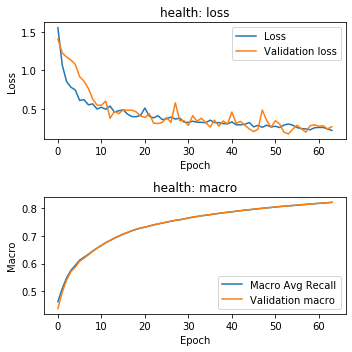

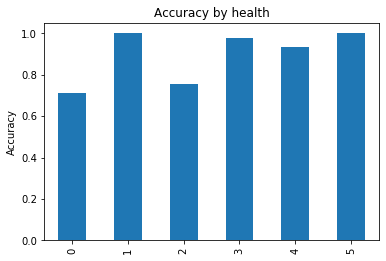

Classification report
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.79      0.71      0.75        69
              ant problems       0.95      1.00      0.98        84
  few varrao, hive beetles       0.73      0.78      0.75        81
                   healthy       0.98      0.98      0.98       584
         hive being robbed       0.91      0.93      0.92        44
             missing queen       1.00      1.00      1.00         5

                  accuracy                           0.94       867
                 macro avg       0.90      0.90      0.90       867
              weighted avg       0.94      0.94      0.94       867

Loss function: 0.15982720255851746


In [30]:
utils.eval_model(training1, model1, test_X, test_y, 'health')

In [31]:
trainedmodelname = modelname + '_{:02d}_{:.2f}.h5'.format(bestepoch.best_epoch, bestepoch.best_loss)
model1.save(trainedmodelname)

In [32]:
saved_model = keras.models.load_model(trainedmodelname, 
                                      custom_objects = {'MacroAverageRecallMetric' : utils.MacroAverageRecallMetric})

In [33]:
df_health = utils.load_test_and_generate_prediction_file(model1, img_width, img_height, img_channels, 'health')
df_health

,id,expected
0,0,hive being robbed
1,1,healthy
2,2,"Varroa, Small Hive Beetles"
3,3,ant problems
4,4,healthy
...,...,...
1702,1702,healthy
1703,1703,"few varrao, hive beetles"
1704,1704,ant problems
1705,1705,healthy
